In [1]:
import pandas as pd
import numpy as np

from utils import *

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 05:00:39.976594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 05:00:39.996830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 05:00:40.003077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 05:00:40.019653: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow bina

# 1. Load Data

In [4]:
gene_expression = pd.read_csv('dataset/Genelevel_expectedcounts_matrix.tsv', sep='\t')
gene_info = pd.read_csv('dataset/gene_info.tsv', sep='\t')
meta_data = pd.read_csv('dataset/MetaSheet.csv', encoding='unicode_escape')

### Preprocess Data

In [30]:
# gene expression data
gene_expression.drop(columns=['Unnamed: 0'], inplace=True)
gene_expression = gene_expression.T

In [ ]:
# meta data
phase_1_indices = meta_data[meta_data['mgs_level'] == 1]['r_id']
phase_2_indices = meta_data[meta_data['mgs_level'] == 2]['r_id']
phase_3_indices = meta_data[meta_data['mgs_level'] == 3]['r_id']
phase_4_indices = meta_data[meta_data['mgs_level'] == 4]['r_id']

phase_1 = gene_expression.loc[phase_1_indices]
phase_2 = gene_expression.loc[phase_2_indices]
phase_3 = gene_expression.loc[phase_3_indices]
phase_4 = gene_expression.loc[phase_4_indices]

**If you are using the aak dataset**

In [5]:
gene_expression = pd.read_csv('dataset/aak81Dataset.csv')
meta_data = pd.DataFrame(gene_expression['mgs_level'])

In [6]:
gene_expression.drop(columns=['sample_id', 'Unnamed: 0', 'mgs_level'], inplace=True)

In [7]:
phase_1_indices = meta_data[meta_data['mgs_level'] == 'MGS1'].index
phase_2_indices = meta_data[meta_data['mgs_level'] == 'MGS2'].index
phase_3_indices = meta_data[meta_data['mgs_level'] == 'MGS3'].index
phase_4_indices = meta_data[meta_data['mgs_level'] == 'MGS4'].index

phase_1 = gene_expression.loc[phase_1_indices]
phase_2 = gene_expression.loc[phase_2_indices]
phase_3 = gene_expression.loc[phase_3_indices]
phase_4 = gene_expression.loc[phase_4_indices]

# 2. CS-CORE Method

In [8]:
# hyperparameters
num_genes = 81

### Compute the most expressed genes

In [9]:
top_gene_indices, gene_names = compute_top_genes(gene_expression, num_genes, gene_info)

**If you are using the aak dataset**

In [10]:
top_gene_indices = [int(i) for i in range(num_genes)]
gene_names = gene_expression.columns

### Compute the most varying genes among different phases (F-test)

In [6]:
f_test_res = f_test_gene_variances(phase_1, phase_4)

f_test_res.sort_values(by='f_statistic', ascending=False, inplace=True)
# drop the inf values and the NaN values
f_test_res = f_test_res.replace([np.inf, -np.inf], np.nan).dropna()

In [7]:
top_gene_indices = f_test_res[:num_genes].index
gene_names = gene_info.loc[top_gene_indices]['external_gene_name']

### CSCORE over the Whole Dataset

In [82]:
general_results = calc_CSCORE(gene_expression, num_genes, gene_info, top_gene_indices=top_gene_indices)

IRLS converged after 3 iterations.
45 among 81 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
1.6766% co-expression estimates were greater than 1 and were set to 1.
1.8290% co-expression estimates were greater than 1 and were set to 1.


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:102: RuntimeWarning: invalid value encountered in sqrt
  test_stat = num / np.sqrt(deno)


### Ablation Study for MGS_level

In [9]:
phase_1_results = calc_CSCORE(phase_1, num_genes, gene_info, top_gene_indices)
# phase_2_results = calc_CSCORE(phase_2, num_genes, gene_info, top_gene_indices)
# phase_3_results = calc_CSCORE(phase_3, num_genes, gene_info, top_gene_indices)
phase_4_results = calc_CSCORE(phase_4, num_genes, gene_info, top_gene_indices)

IRLS converged after 3 iterations.
53 among 81 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
0.7926% co-expression estimates were greater than 1 and were set to 1.
0.8840% co-expression estimates were greater than 1 and were set to 1.
IRLS converged after 3 iterations.
43 among 81 genes have negative variance estimates. Their co-expressions with other genes were set to 0.
1.6156% co-expression estimates were greater than 1 and were set to 1.
1.8595% co-expression estimates were greater than 1 and were set to 1.


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:102: RuntimeWarning: invalid value encountered in sqrt
  test_stat = num / np.sqrt(deno)
/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/CSCORE/CSCORE_IRLS.py:102: RuntimeWarning: invalid value encountered in sqrt
  test_stat = num / np.sqrt(deno)


In [ ]:
# save results
np.save('results/co_expression/general_results.npy', general_results[0])

np.save('results/co_expression/phase_1_results.npy', phase_1_results[0])
np.save('results/co_expression/phase_2_results.npy', phase_2_results[0])
np.save('results/co_expression/phase_3_results.npy', phase_3_results[0])
np.save('results/co_expression/phase_4_results.npy', phase_4_results[0])

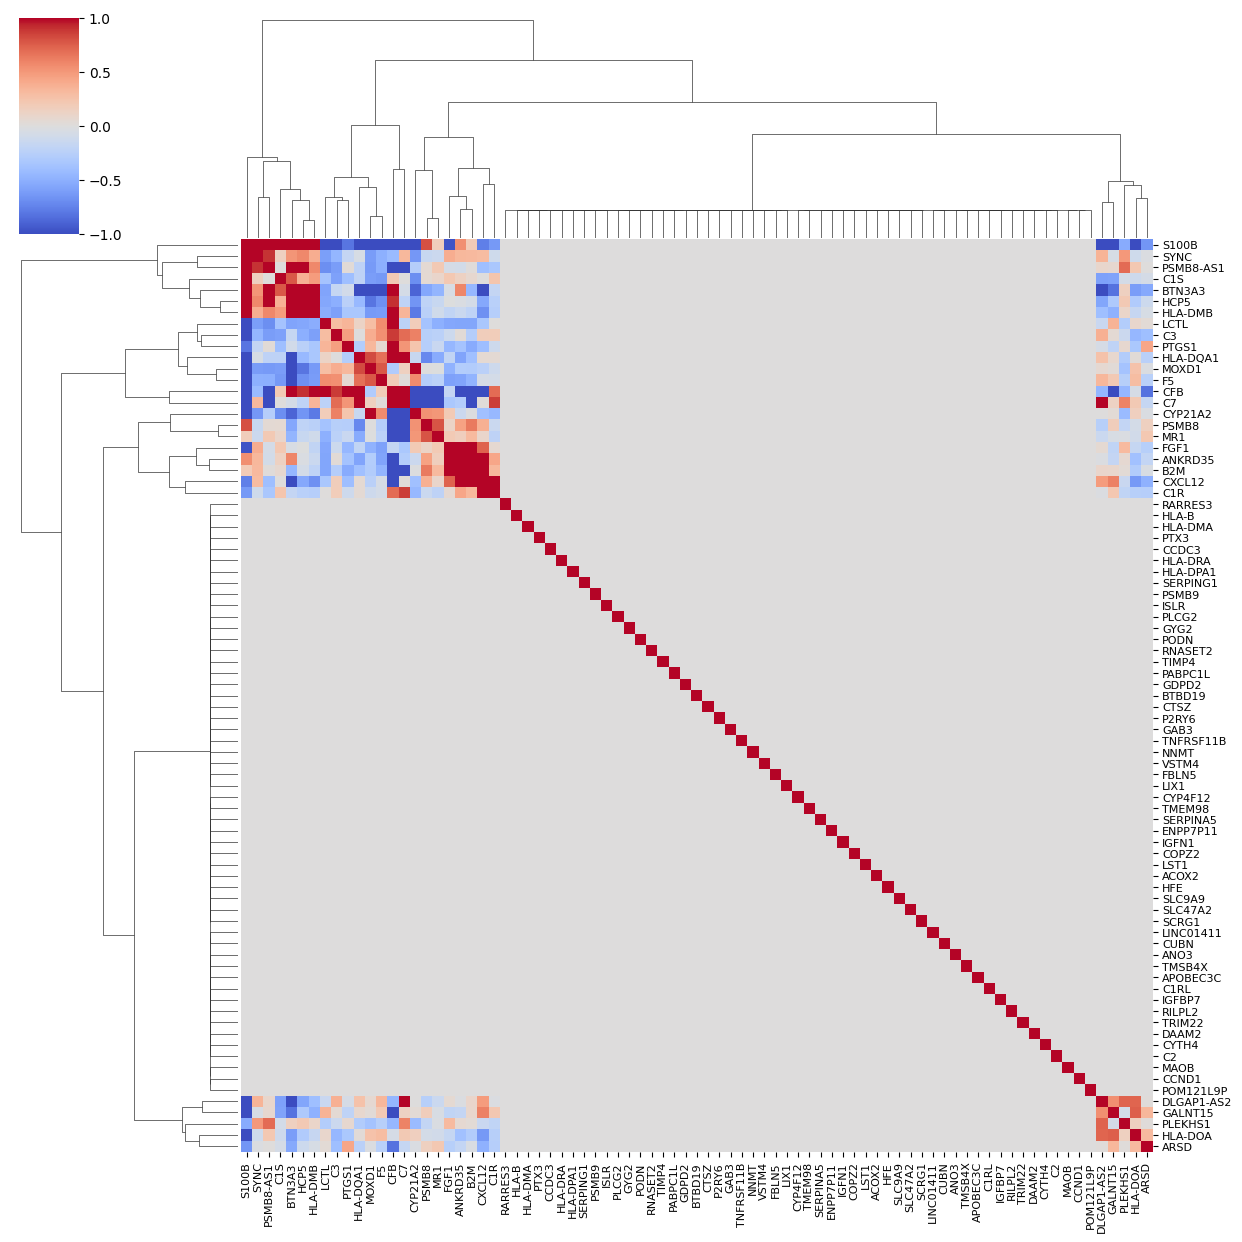

In [10]:
plot_clustermap(phase_1_results[0], gene_names)

# 3. Clustering

In [ ]:
# reset index
gene_names = gene_names.reset_index(drop=True)

### Generate Graph using Networkx

In [13]:
general_clustering = calculate_coexpression_graph(phase_4_results[0], gene_names, threshold=0.2)

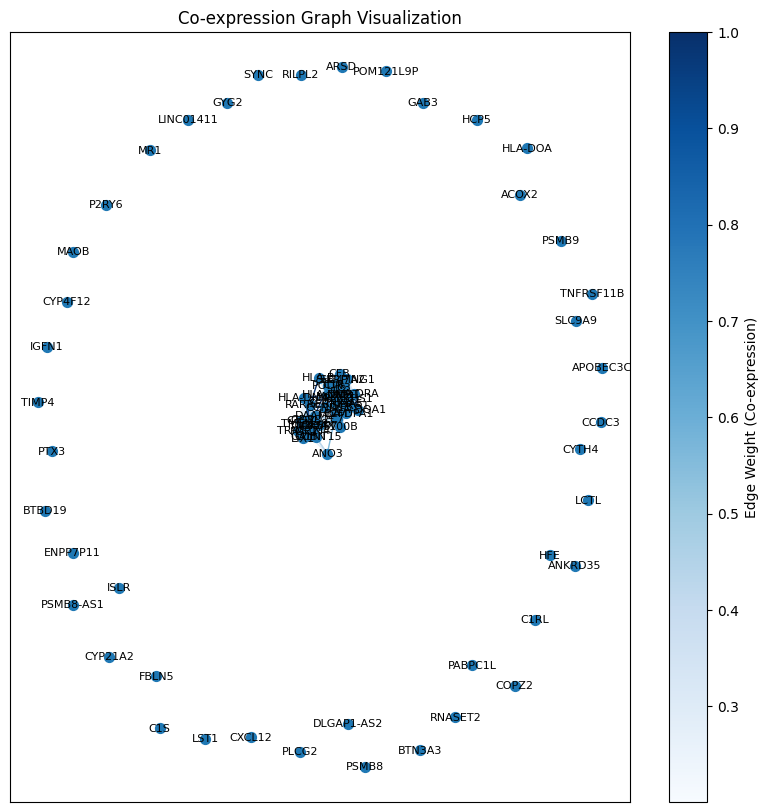

In [14]:
visualize_coexpression_graph(general_clustering)

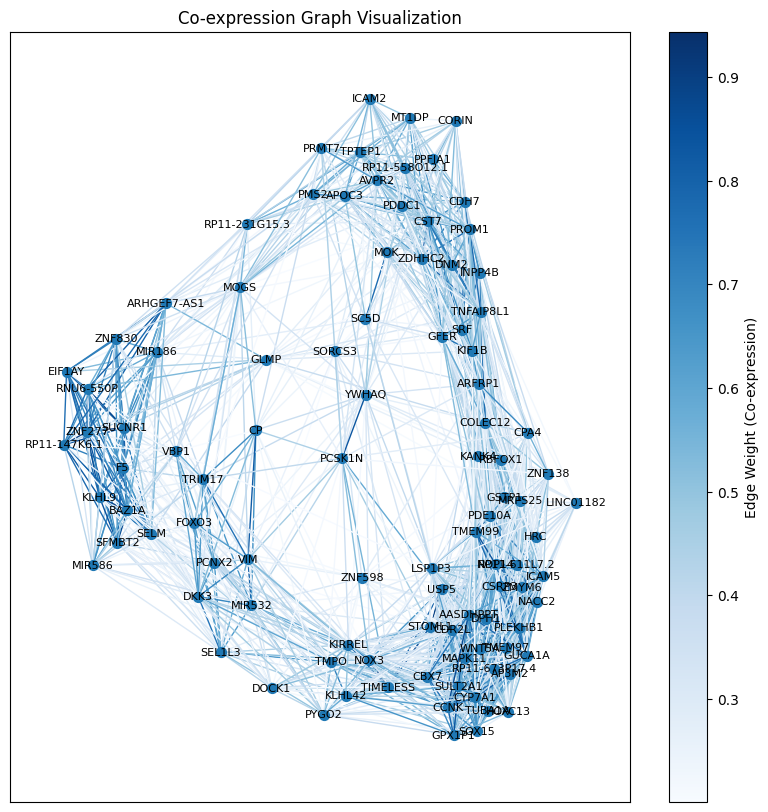

In [26]:
# handle outliers
general_clustering.remove_node('LINC00659')
visualize_coexpression_graph(general_clustering)

### Generate Gene Embeddings from Graph

In [90]:
# hyperparameters
dimensions = 32
n_clusters = 4
p = 1
q = 1

In [91]:
general_embedding = graph_to_node2vec_embeddings(general_clustering, dimensions=dimensions, p=p, q=q)

Computing transition probabilities: 100%|██████████| 81/81 [00:00<00:00, 3422.89it/s]


Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 661.74it/s]


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


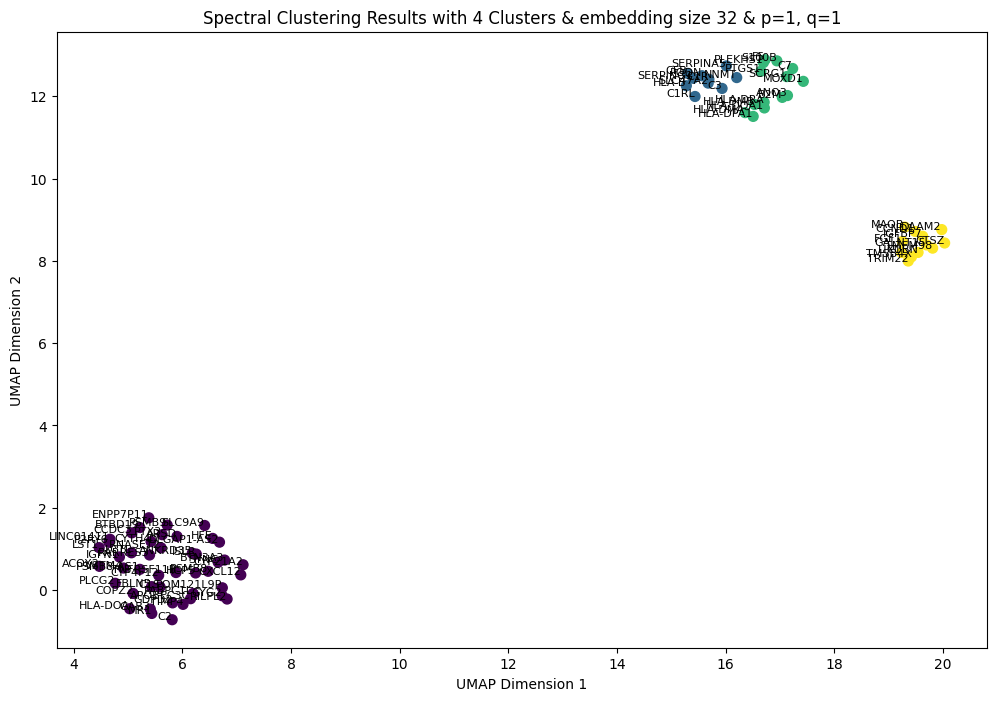

In [93]:
labels = plot_dendrogram_with_embeddings(
    general_embedding, gene_names.tolist(), 
    dimensions, n_clusters=n_clusters, p=p, q=q
)

### Ablation Study for MGS_level

In [94]:
phase_1_clustering = calculate_coexpression_graph(phase_1_results[0], gene_names, threshold=0.2)
# phase_2_clustering = calculate_coexpression_graph(phase_2_results[0], gene_names, threshold=0.2)
# phase_3_clustering = calculate_coexpression_graph(phase_3_results[0], gene_names, threshold=0.2)
phase_4_clustering = calculate_coexpression_graph(phase_4_results[0], gene_names, threshold=0.2)

In [95]:
phase_1_embedding = graph_to_node2vec_embeddings(phase_1_clustering, dimensions=dimensions, p=p, q=q)
# phase_2_embedding = graph_to_node2vec_embeddings(phase_2_clustering, dimensions=dimensions, p=p, q=q)
# phase_3_embedding = graph_to_node2vec_embeddings(phase_3_clustering, dimensions=dimensions, p=p, q=q)
phase_4_embedding = graph_to_node2vec_embeddings(phase_4_clustering, dimensions=dimensions, p=p, q=q)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 594.85it/s]


/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


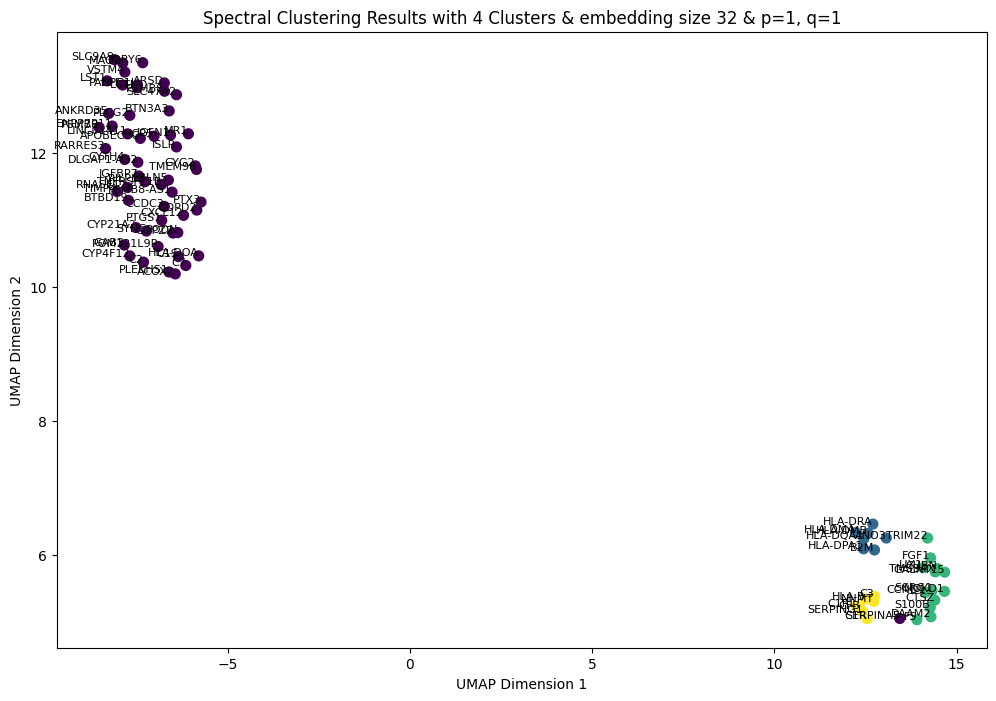

/home/zx22/anaconda3/envs/gene/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


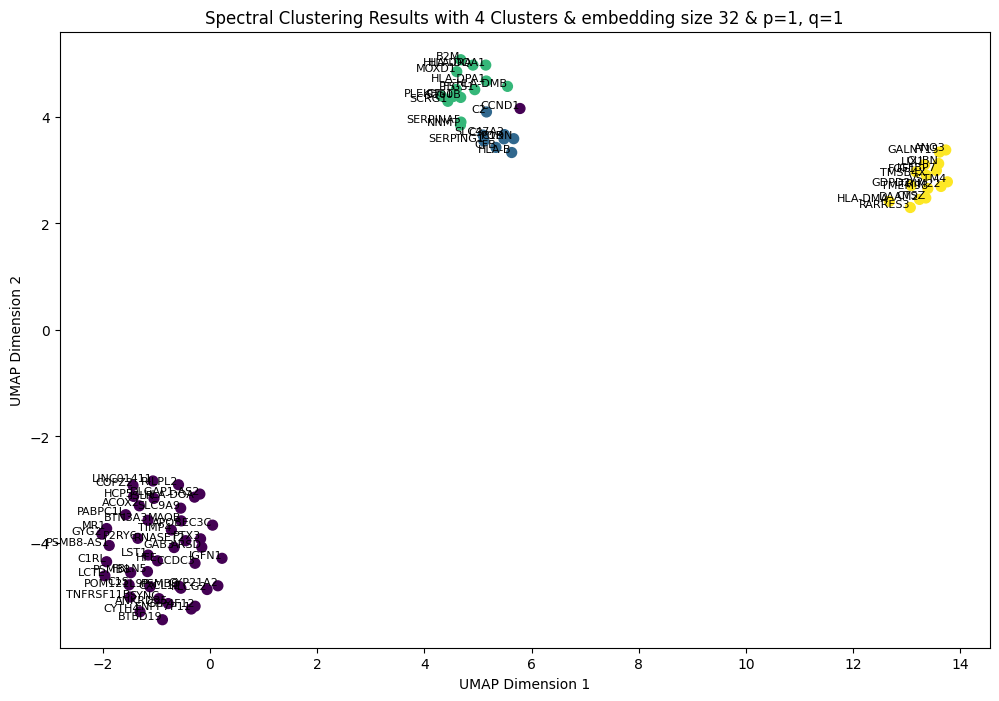

In [97]:
phase_1_labels = plot_dendrogram_with_embeddings(phase_1_embedding, gene_names.tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
# phase_2_labels = plot_dendrogram_with_embeddings(phase_2_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
# phase_3_labels = plot_dendrogram_with_embeddings(phase_3_embedding, gene_names.squeeze().tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)
phase_4_labels = plot_dendrogram_with_embeddings(phase_4_embedding, gene_names.tolist(), dimensions, n_clusters=n_clusters, p=p, q=q)

In [98]:
# analyze clusters from different phases
cluster_labels = pd.concat([
    pd.DataFrame(gene_names), 
    pd.DataFrame(labels),
    pd.DataFrame(phase_1_labels),
    # pd.DataFrame(phase_2_labels),
    # pd.DataFrame(phase_3_labels),
    pd.DataFrame(phase_4_labels)
], axis=1)
cluster_labels.columns = ['gene', 'general', 'phase_1', 'phase_4']

cluster_labels.to_csv('results/embedding_cluster_labels_F_test.csv', index=False)

In [99]:
cluster_labels

,gene,general,phase_1,phase_4
0,S100B,2,2,2
1,SYNC,0,0,0
2,PSMB8-AS1,0,0,0
3,C1S,0,0,0
4,BTN3A3,0,0,0
...,...,...,...,...
76,DLGAP1-AS2,0,0,0
77,GALNT15,3,2,3
78,PLEKHS1,2,0,2
79,HLA-DOA,0,0,0


## DBSCAN Clustering

In [12]:
phase_1_results = np.load('results/co_expression/aak_phase_1_results.npy')
phase_4_results = np.load('results/co_expression/aak_phase_4_results.npy')

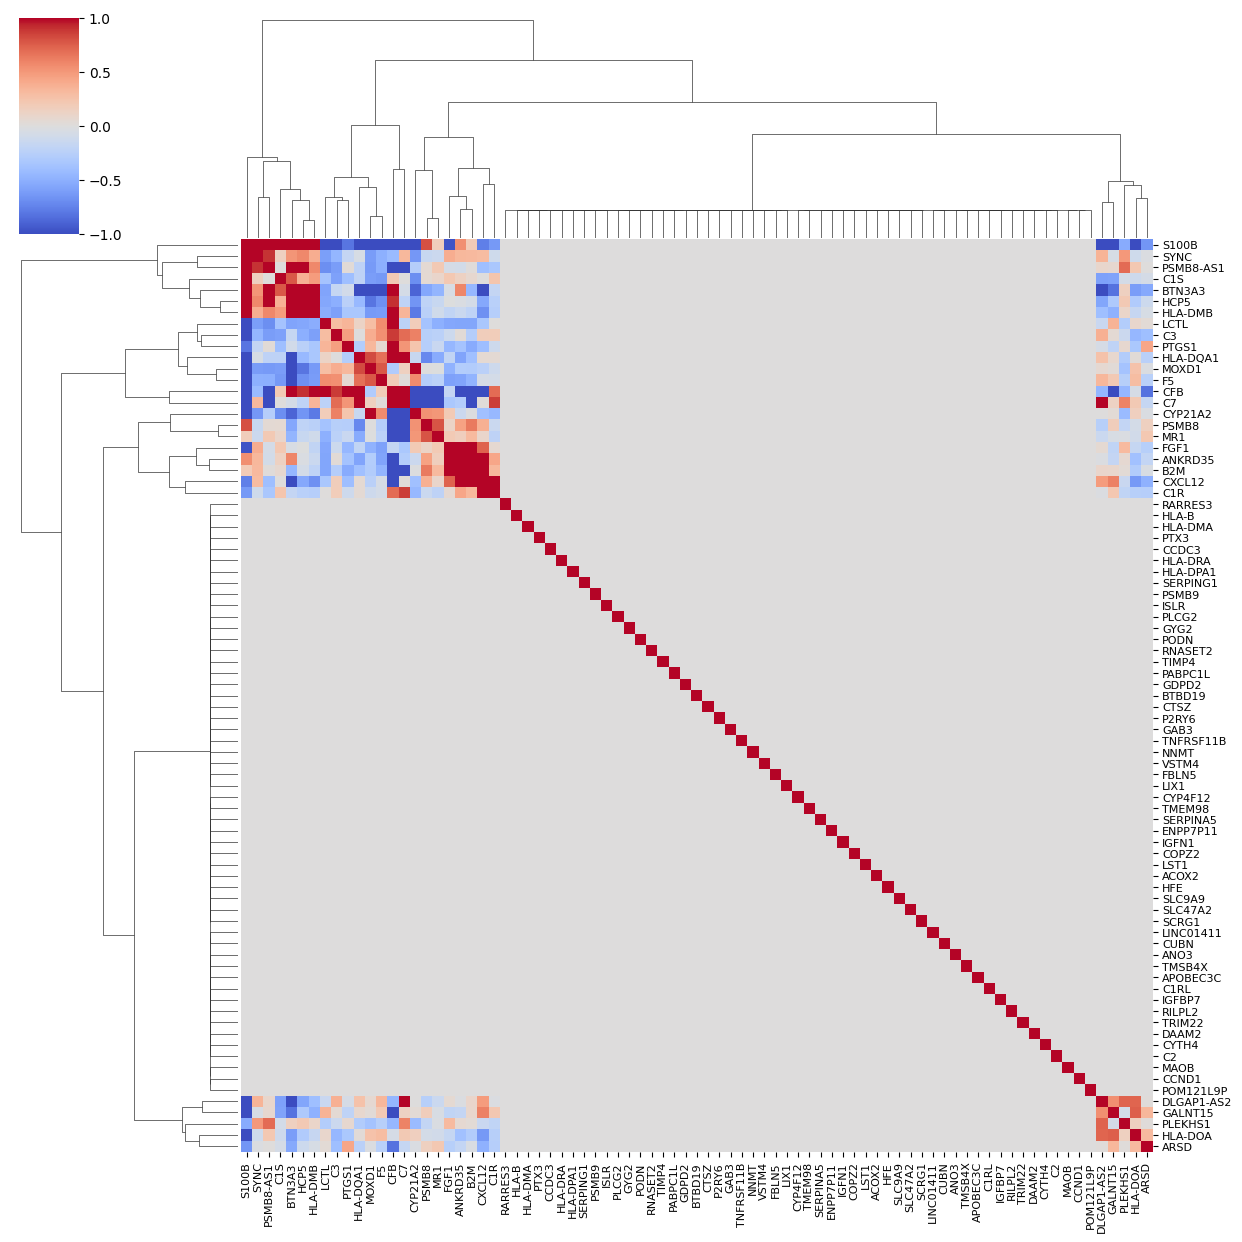

In [32]:
phase1_DBSCAN_res = cluster_correlation_matrix(phase_1_results, gene_names, eps=0.05)

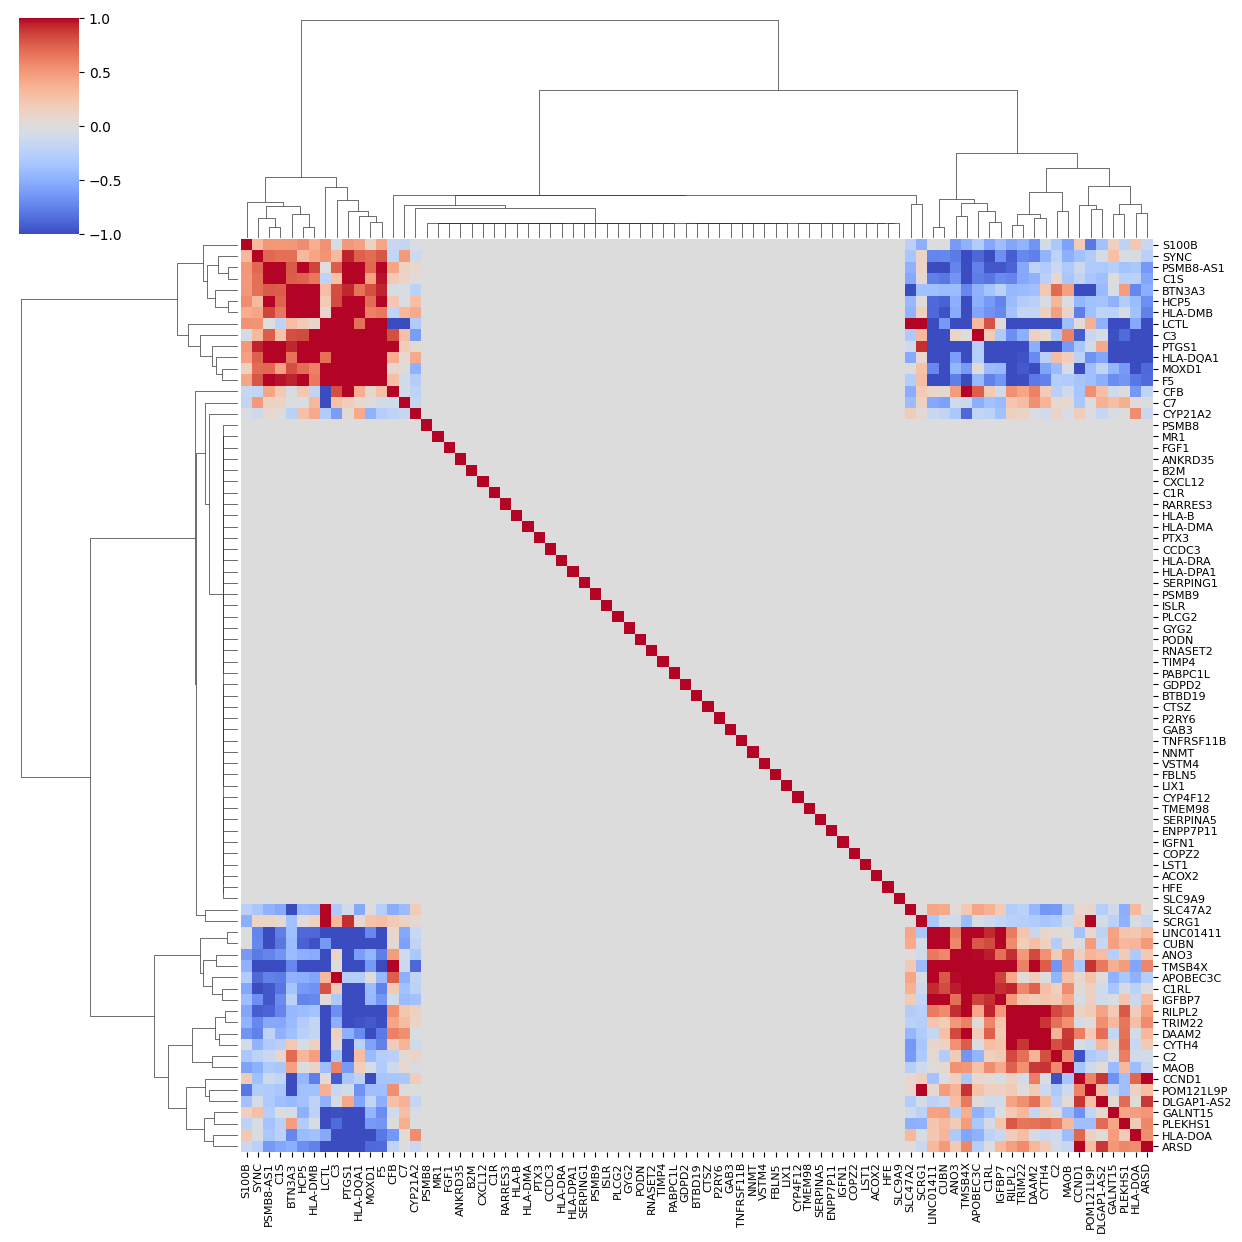

In [34]:
phase4_DBSCAN_res = cluster_correlation_matrix(phase_4_results, gene_names, eps=0.05)